In [18]:
import numpy as np
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

ACTION_B = 10
GAMMA =  1.
ALPHA = 0.1
EPSILON = 0.1

TOTAL_EPOSIDE_NUM = 600
RUN_TIMES = 1_000 # 每个 episode 测试的次数
accessable_action = {"Start":[1,2],"Terminal":[1],"B":list(range(1,ACTION_B+1))}

def action_B(a):
    assert (a>=1) and (a<=ACTION_B)
    return np.random.normal(loc=-0.1, scale=1), "Terminal"

def action_Start(direction):
    if direction == 1:
        return 0, "B"
    elif direction == 2:
        return 0, "Terminal"

def init_Q_table():
    # 采用全零初始化
    Q_table = pd.DataFrame(index=["B"],columns=np.arange(1,ACTION_B+1), data= 0) #np.random.normal(loc=0., scale=.5, size= (2,ACTION_B)))
    Q_table.loc["Terminal",1] = 0
    Q_table.loc["Start",[1,2]] = [0,0] #np.random.normal(loc=0., scale=.5, size= (2,))
    return Q_table

def Q_learning(RUN_INDEX,store_bias = []):

    # 初始化
    Q_table = init_Q_table()

    for i in range(1,TOTAL_EPOSIDE_NUM+1):
        COUNT_LEFT = 0

        state = "Start" # 从 Start 开始
        while state != "Terminal": # 下面的 state 不可能是 Terminal
            epsilon = np.random.random()
            if epsilon >= EPSILON:
                action_available = accessable_action[state]
                np.random.shuffle(action_available)
                action_todo = action_available[np.argmax(Q_table.loc[state,action_available])] # start 位置 1 表示向左 2 表示向右        
            else:
                action_todo = np.random.choice(accessable_action[state])
            
            if action_todo == 1 and state == "Start":
                COUNT_LEFT += 1
            
            if state == "Start":
                reward,next_state = action_Start(action_todo)
            elif state == "B":
                reward,next_state = action_B(action_todo)
            
            Q_table.loc[state,action_todo] += ALPHA*(reward + GAMMA * np.max(Q_table.loc[next_state]) \
                                                    - Q_table.loc[state,action_todo])
            state = next_state

        store_bias.append([RUN_INDEX,i,COUNT_LEFT])

    return store_bias


def double_Q_learning(RUN_INDEX,store_bias = []):

    # 初始化
    Q_table1 = init_Q_table()
    Q_table2 = init_Q_table()

    for i in range(1,TOTAL_EPOSIDE_NUM+1):
        COUNT_LEFT = 0

        state = "Start" # 从 Start 开始
        while state != "Terminal": # 下面的 state 不可能是 Terminal
            epsilon = np.random.random()
            if epsilon >= EPSILON:
                action_available = accessable_action[state]
                np.random.shuffle(action_available)
                action_todo = action_available[np.argmax(Q_table1.loc[state,action_available]+Q_table2.loc[state,action_available])] 
                # start 位置 1 表示向左 2 表示向右        
            else:
                action_todo = np.random.choice(accessable_action[state])
            
            if action_todo == 1 and state == "Start":
                COUNT_LEFT += 1
            
            if state == "Start":
                reward,next_state = action_Start(action_todo)
            elif state == "B":
                reward,next_state = action_B(action_todo)
            
            epsilon = np.random.random()
            if epsilon >= 0.5:
                action_available = accessable_action[next_state]
                np.random.shuffle(action_available)
                action_todo_next = action_available[np.argmax(Q_table1.loc[next_state,action_available])] # 从 Q_table1 获得

                Q_table1.loc[state,action_todo] +=  ALPHA*(reward + GAMMA * Q_table2.loc[next_state,action_todo_next] \
                                                            - Q_table1.loc[state,action_todo])
            else:
                action_available = accessable_action[next_state]
                np.random.shuffle(action_available)
                action_todo_next = action_available[np.argmax(Q_table2.loc[next_state,action_available])] # 从 Q_table2 获得

                Q_table2.loc[state,action_todo] += ALPHA*(reward + GAMMA * Q_table1.loc[next_state,action_todo_next] \
                                                          - Q_table2.loc[state,action_todo])
            state = next_state
        store_bias.append([RUN_INDEX,i,COUNT_LEFT])

    return store_bias

In [19]:
from joblib import Parallel, delayed
from multiprocessing import Manager
manager = Manager()
store_bias_q= []
store_bias_q = Parallel(n_jobs=10,verbose=1)(delayed(Q_learning)(i,store_bias_q) for i in range(RUN_TIMES))

store_bias_qdouble = []
store_bias_qdouble = Parallel(n_jobs=10,verbose=1)(delayed(double_Q_learning)(i,store_bias_qdouble) for i in range(RUN_TIMES))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   11.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   25.5s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   44.7s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:   56.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   19.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   46.6s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:  1.8min finished


In [20]:
df = pd.DataFrame({"run_index":[x[0] for j in range(RUN_TIMES) for x in store_bias_q[j]], 
                   "episode_num":[x[1] for j in range(RUN_TIMES) for x in store_bias_q[j]], 
                   "left_ratio":[x[2] for j in range(RUN_TIMES) for x in store_bias_q[j]]})
df = df[["episode_num","left_ratio"]]
df = df.groupby(["episode_num"]).mean("left_ratio")

df2 = pd.DataFrame({"run_index":[x[0] for j in range(RUN_TIMES) for x in store_bias_qdouble[j]], 
                   "episode_num":[x[1] for j in range(RUN_TIMES) for x in store_bias_qdouble[j]], 
                   "left_ratio":[x[2] for j in range(RUN_TIMES) for x in store_bias_qdouble[j]]})
df2 = df2[["episode_num","left_ratio"]]
df2 = df2.groupby(["episode_num"]).mean("left_ratio")

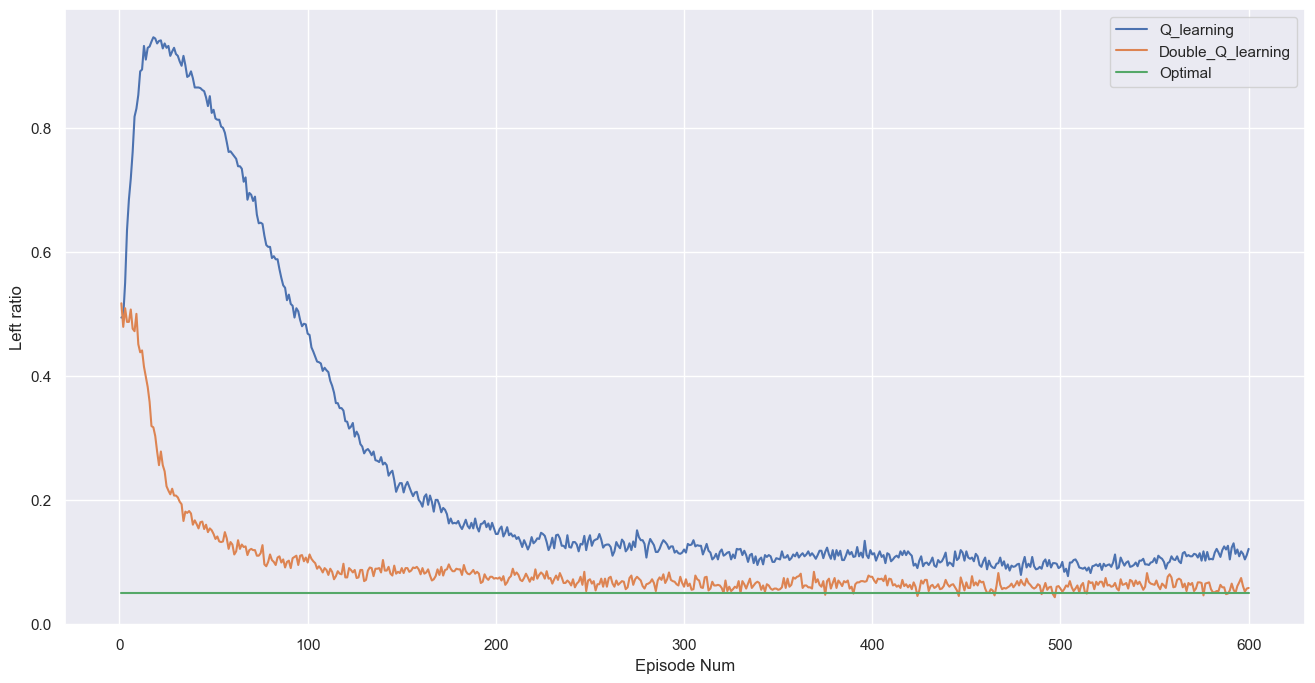

In [21]:
plt.figure(figsize=(16,8))
plt.plot(df.index,df.values,label = "Q_learning")
plt.plot(df2.index,df2.values, label = "Double_Q_learning")
plt.plot(df2.index,[0.05]*len(df2.values), label = "Optimal")
plt.xlabel("Episode Num")
plt.ylabel("Left ratio")
plt.legend()